## Overview

Thanks for reading. I would like to share time series RNN approach.<br>
This notebook is almost implementaion of [Recurrent Neural Networks For Accurate RSSI Indoor Localization](https://arxiv.org/pdf/1903.11703.pdf).
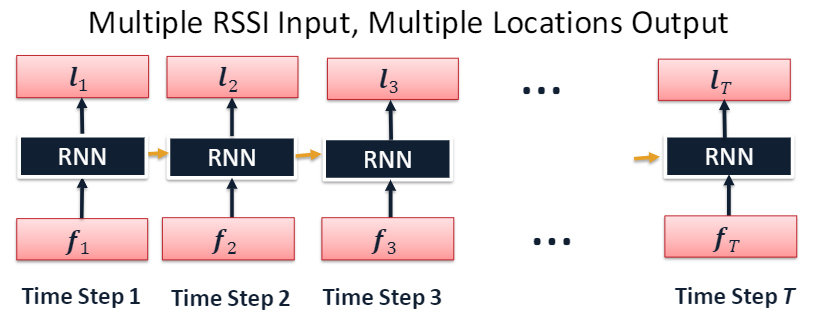
### dataset
My [time sequence unified  wifi dataset](https://www.kaggle.com/ebinan92/time-sequence-unified-wifi/metadata) is made from two exellent notebooks.
* [LSTM by Keras with Unified Wi-Fi Feats](https://www.kaggle.com/kokitanisaka/lstm-by-keras-with-unified-wi-fi-feats) by [@Kouki](https://www.kaggle.com/kokitanisaka)<br>
* [Indoor GBM+postprocessing XY prediction](https://www.kaggle.com/oxzplvifi/indoor-gbm-postprocessing-xy-prediction) by [@Oscar Villarreal Escamilla](https://www.kaggle.com/oxzplvifi)<br>

The main difference between my dataset and [@kouki's dataset](https://www.kaggle.com/kokitanisaka/indoorunifiedwifids) is t1_wifi column.
Can be treated as time series data by this column. I'll upload dataset notebook if really needed.

### model
* One hot encoding for bssi features of all test's building is intractable. So I used entity embedding approch followed by @kouki.
* Many models are possible, but here for simplicity. I used many to many rnn model.


In [ ]:
import random
from random import sample
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
import gc
import torch.nn as nn
from torch.utils.data import Dataset
import torch
import matplotlib.pyplot as plt
from scipy.ndimage.filters import uniform_filter1d
from scipy.interpolate import interp1d
import numpy as np 
import pandas as pd  
import torch.nn as nn
import os
import time
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler, LabelEncoder
from collections import defaultdict

EPOCH = 50
BATCH_SIZE = 256
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MEMORY_LENGTH = 5 # max sequence length
WIFI_NUM = 50
FOLDS = 10
inpath = '../input/indoor-location-navigation/'
metapath = inpath + 'metadata'
trainpath = inpath + 'train'
testpath = inpath + 'test'

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_seed()

In [ ]:
sample_submission = pd.read_csv('../input/indoor-location-navigation/sample_submission.csv')

Procedure to produce floor results through KMeans+GBM @ https://www.kaggle.com/oxzplvifi/indoor-kmeans-gbm-floor-prediction

In [ ]:
floors = pd.read_csv('/kaggle/input/indoor-xy-floor/result_floor_feb22.csv',index_col=0)
floors.head()

The main difference between my dataset and [@kouki's dataset](https://www.kaggle.com/kokitanisaka/indoorunifiedwifids) is t1_wifi column.
We can treat as time series data by this column.
I haven't deleted bssids by the frequency of bssids. 

In [ ]:
train_data = pd.read_csv('../input/time-series-unified-wifi/train_all.csv',index_col=0)
test_data = pd.read_csv('../input/time-series-unified-wifi/test_all.csv',index_col=0)
train_data

Long sequence is not learnable. make sure each paths length is shorter than memory_length. 

In [ ]:
del_path = []
new_trains = []
for i, (p, g) in enumerate(train_data.groupby('path_id')):
    if len(g) > MEMORY_LENGTH:
        del_path.append(p)
        for j in range((len(g) // MEMORY_LENGTH) + 1):
            if j == (len(g) // MEMORY_LENGTH):
                tmp = g.iloc[j*MEMORY_LENGTH:]
            else:
                tmp = g.iloc[j*MEMORY_LENGTH:(j+1)*MEMORY_LENGTH]
            tmp.loc[:, 'path_id'] = p + '_' + str(j)
            new_trains.append(tmp)
        
train_data.drop(train_data[train_data['path_id'].isin(del_path)].index, inplace=True)
train_data = pd.concat([train_data, pd.concat(new_trains)]).reset_index(drop=True)
print(f"previous path len:{i+1}, current path len:{len(train_data.groupby('path_id'))}")
del new_trains
gc.collect()

preparation

In [ ]:
BSSID_FEATS = [f'wb_{i}' for i in range(WIFI_NUM)]
RSSI_FEATS = [f'wr_{i}' for i in range(WIFI_NUM)]
X_train = train_data.loc[:, ['t1_wifi', 'building',
                             'path_id'] + BSSID_FEATS + RSSI_FEATS]
y_train = train_data.loc[:, ['t1_wifi', 'path_id', 'x', 'y', 'building']]
X_test = test_data.loc[:, ['t1_wifi', 'building',
                           'path_id'] + BSSID_FEATS + RSSI_FEATS]

### building weight
test_data frequency / train_data frequency 

In [ ]:
test_building_weight = defaultdict(int)
train_building_weight = defaultdict(int)
building_weight = dict()

for building in [x.split('_')[0] for x in sample_submission['site_path_timestamp'].values]:
    test_building_weight[building] += 1 * 24/len(sample_submission)
    
for building in train_data['building'].values:
    train_building_weight[building] += 1
train_building_weight = dict((k, len(train_data)/24/v) for k, v in train_building_weight.items())

for building in list(train_building_weight.keys()):
    building_weight[building] = train_building_weight[building] * test_building_weight[building]
    
y_train['weight'] = [building_weight[x] for x in y_train['building'].values]

### normalization

In [ ]:
le = LabelEncoder()
unique_bssids = np.unique(X_train.loc[:, BSSID_FEATS].values.tolist(
) + X_test.loc[:, BSSID_FEATS].values.tolist())
wifi_bssids_size = len(unique_bssids)
print(f"bssids_size: {wifi_bssids_size}")
le.fit(unique_bssids)
le_site = LabelEncoder()
le_site.fit(list(set(X_train.loc[:, 'building'].values.tolist())))

x_min = np.min(y_train.loc[:, 'x'].values)
y_min = np.min(y_train.loc[:, 'y'].values)
norm_x = np.max(y_train.loc[:, 'x'].values) - x_min
norm_y = np.max(y_train.loc[:, 'y'].values) - y_min

X_train.loc[:, RSSI_FEATS] = (X_train.loc[:, RSSI_FEATS] + 99) / (np.max(X_train.loc[:, RSSI_FEATS].values) + 99)
X_test.loc[:, RSSI_FEATS] = (X_test.loc[:, RSSI_FEATS] +99) / (np.max(X_train.loc[:, RSSI_FEATS].values) + 99)
y_train.loc[:, 'x'] = (y_train.loc[:, 'x'] - x_min) / norm_x
y_train.loc[:, 'y'] = (y_train.loc[:, 'y'] - y_min) / norm_y


for i in BSSID_FEATS:
    X_train.loc[:, i] = le.transform(X_train.loc[:, i])
    X_test.loc[:, i] = le.transform(X_test.loc[:, i])
X_train.loc[:, 'building'] = le_site.transform(X_train.loc[:, 'building'])
X_test.loc[:, 'building'] = le_site.transform(X_test.loc[:, 'building'])

test_data.set_index(['path_id', 't1_wifi'], inplace=True)
result = pd.DataFrame(np.zeros([len(test_data), 2]),
                     index=test_data.index, columns=['x', 'y'])
del train_data, test_data
gc.collect()

group by path_id and sort by t1_wifi

In [ ]:
def make_data(data, col):
    train = []
    for _, group in data.groupby('path_id'):
        group = group.sort_values('t1_wifi')
        train.append(group[col])
    return train

train_cols = ['building'] + BSSID_FEATS + RSSI_FEATS 
y_train = make_data(y_train, col=['x', 'y', 'weight'])
X_train = make_data(X_train, col=train_cols)

### Dataset
I used inverse trajectory and random trajectory as augmentation according to https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7374298/

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, x_train, y_train, transform, inverse_ratio=0.5, combine_ratio=0.2):
        self.transform = transform
        self.x_train = x_train
        self.y_train = y_train
        self.inverse_ratio = inverse_ratio
        self.combine_ratio = combine_ratio

    def __getitem__(self, index):
        x = self.x_train[index]
        y = self.y_train[index]
        mask = torch.tensor(np.full(MEMORY_LENGTH, True, dtype=bool))
        if len(x) < MEMORY_LENGTH:
            x_out = torch.tensor(
                np.pad(x.to_numpy(), ([(0, MEMORY_LENGTH - len(x)), (0, 0)]), 'edge'))
            y_out = torch.tensor(np.pad(
                y.to_numpy(), ([(0, MEMORY_LENGTH - len(x)), (0, 0)]), 'edge'))
            mask[len(x):] = False
        else:
            x_out = torch.tensor(x.to_numpy())
            y_out = torch.tensor(y.to_numpy())

        if self.transform:
            # inverse trajectory
            if np.random.rand() < self.inverse_ratio:
                tmp = torch.arange(MEMORY_LENGTH-1, -1, -1)
                x_out = x_out[tmp, :]
                y_out = y_out[tmp, :]
                mask = mask[tmp]

            # # combine trajectory
            if np.random.rand() < self.combine_ratio:
                p = torch.randperm(MEMORY_LENGTH)
                x_out = x_out[p]
                y_out = y_out[p]
                mask = mask[p]

        return x_out, y_out, mask

    def __len__(self):
        return len(self.x_train)

### model
many to many

In [ ]:
class ManyToMany(nn.Module):
    def __init__(self, wifi_bssids_size, input_dim, hidden_dim):
        super(ManyToMany, self).__init__()
        self.emb_dim = 256
        self.entitity_dim = 128
        self.bssi = nn.Embedding(wifi_bssids_size, self.emb_dim)
        self.building = nn.Embedding(24, 2)

        self.entity1 = nn.Sequential(
            nn.Linear(self.emb_dim + 3, self.entitity_dim),
            nn.Tanh()
        )
        self.entity2 = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(self.entitity_dim*WIFI_NUM, input_dim),
        )
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers=1,batch_first=True)

        self.main = nn.Sequential(
            nn.Linear(hidden_dim, 32),
            nn.ReLU(True),
            nn.Linear(32, 2),
        )

    def forward(self, x):
        bssids = self.bssi(x[:, :, 1:int(WIFI_NUM+1)].long()).float()
        buildings = self.building(x[:, :, 0].long()).unsqueeze(2).expand(-1, -1, WIFI_NUM, -1).float()
        rssis = x[:, :, int(WIFI_NUM+1):int(WIFI_NUM*2+1)].unsqueeze(3).float()
        
        x = torch.cat((bssids,  rssis, buildings), axis=3)
        #(batch, memory_length, wifi_num, self.emb_dim+2+1)
        x = self.entity1(x)
        #(batch, memory_length, wifi_num, self.entity1_dim)
        x = x.flatten(start_dim=2)
        #(batch, memory_length, wifi_num * self.entity1_dim)
        x = self.entity2(x)
        #(batch, memory_length, input_dim)
        output, _ = self.gru(x)
        output = self.main(output)
        #(batch, memory_length, 2)
        return output


utils

In [ ]:
def train_manytomany(t_loader, v_loader, optimizer, criterion, model,norms):
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.6)
    model.train()
    early_stopping = 0
    loss_pred = 100000
    for e in range(EPOCH):
        for (x, y, m) in t_loader:
            optimizer.zero_grad()
            x, y = x.to(DEVICE), y.to(DEVICE).float()
            output = model(x)
            loss = criterion(output[m], y[m])
            loss.backward()
            optimizer.step()
        scheduler.step()
        if (e+1) % 1 == 0:
            losses = []
            losses2 = []
            total_point = 0
            with torch.no_grad():
                for (x, y, m) in v_loader:
                    x, y = x.to(DEVICE), y.to(DEVICE).float()
                    output = model(x)
                    loss = comp_metric_xy(output[m], y[m], norms)
                    loss2 = comp_metric_weighted_xy(output[m], y[m], norms)
                    losses.append(loss.item())
                    losses2.append(loss2.item())
                    total_point += torch.count_nonzero(m)
                tmp = np.sum(losses)/total_point
                tmp2 = np.sum(losses2)/total_point
                print(
                    f"epoch: {e}, loss: {tmp:.5f}, weight_loss: {tmp2:.5f} lr:{scheduler.get_last_lr()[0]:.5f}")
                if loss_pred < tmp2:
                    early_stopping += 1
                else:
                    early_stopping = 0
                    loss_pred = tmp2
                    model_pred = model
                if early_stopping > 5:
                    return model_pred, loss_pred    
    return model_pred, loss_pred

def comp_metric_xy(output, y, norms):
    return torch.sqrt(((norms*(output - y[:,:2]))**2).sum())
def weighted_mse_loss(output, y):
    return (y[:, 2].reshape(-1,1)*(output - y[:,:2])**2).sum()
def comp_metric_weighted_xy(output, y, norms):
    return torch.sqrt(((y[:, 2].reshape(-1,1)*(norms * (output - y[:,:2]))**2)).sum())

train

In [ ]:
buildings = []
for x in X_train:
    buildings.append(x.iloc[0, 0])

loss_folds = []
skf = StratifiedKFold(n_splits=FOLDS)
criterion = weighted_mse_loss
norms = torch.tensor([[norm_x, norm_y]]).to(DEVICE)
start = time.time()
for fold, (idt, idv) in enumerate(skf.split(X_train, buildings)):
    print('\r', f'{fold}', end='\t')
    mtrain, mvalid = [X_train[i] for i in idt], [y_train[i] for i in idt]
    ltrain, lvalid = [X_train[i] for i in idv], [y_train[i] for i in idv]
    t_loader = DataLoader(CustomDataset(
        mtrain, mvalid, transform=True), batch_size=BATCH_SIZE, shuffle=True)
    v_loader = DataLoader(CustomDataset(
        ltrain, lvalid, transform=False), batch_size=BATCH_SIZE, shuffle=False)

    model = ManyToMany(wifi_bssids_size, 64, 128).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=0.005)
    
    model, loss = train_manytomany(
        t_loader, v_loader, optimizer, criterion, model, norms)

    # prediction by sliding window averaging. see https://arxiv.org/pdf/1903.11703.pdf
    prediction = []
    with torch.no_grad():
        for p, x in X_test.groupby('path_id'):
            window_score = defaultdict(list)
            x = x.sort_values('t1_wifi')
            ts = x['t1_wifi'].to_numpy()
            x = x[train_cols].reset_index(drop=True)
            
            for window in range(len(ts)):
                if MEMORY_LENGTH + window > len(ts):
                    break
                
                x_out = torch.tensor(
                    x.iloc[window:(window+MEMORY_LENGTH)].to_numpy())
                x_out = x_out.unsqueeze(0)
                x_out = model(x_out.to(DEVICE))
                for i in range(MEMORY_LENGTH):
                    window_score[ts[window + i]].append(x_out.squeeze().cpu().detach().numpy()[i,:])
                
            #  sort by time and get average 
            window_score = sorted(window_score.items(), key=lambda x:x[0])
            prediction.extend(list(map(lambda x: np.mean(x[1],axis=0), window_score)))

    prediction = np.array(prediction)
    result['x'] += (prediction[:, 0] * norm_x + x_min) / FOLDS
    result['y'] += (prediction[:, 1] * norm_y + y_min) / FOLDS
    loss_folds.append(loss)
    print(f'fold: {fold}, loss: {loss}')
    
    del mtrain, mvalid, ltrain, lvalid, t_loader, v_loader, model, prediction
    gc.collect()
    

print(f"mean loss: {np.mean(loss_folds)}, time:{(start -time.time())/60:.1f} min.")

Post processing is same as [Indoor GBM+postprocessing XY prediction](https://www.kaggle.com/oxzplvifi/indoor-gbm-postprocessing-xy-prediction) by [@Oscar Villarreal Escamilla](https://www.kaggle.com/oxzplvifi)<br>

In [ ]:
sample_submission['building'] = [x.split('_')[0] for x in sample_submission['site_path_timestamp']]
sample_submission['path_id'] = [x.split('_')[1] for x in sample_submission['site_path_timestamp']]
sample_submission['timestamp'] = [x.split('_')[2] for x in sample_submission['site_path_timestamp']]
samples = pd.DataFrame(sample_submission.groupby(['building','path_id'])['timestamp'].apply(lambda x: list(x)))
buildings = np.unique([x[0] for x in samples.index])
samples.head()

In [ ]:
result.reset_index(inplace=True)
result.set_index('path_id', inplace=True)
result

In [ ]:
from scipy.spatial.transform import Rotation as R
from PIL import Image
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objs as go
from pathlib import Path
import scipy.signal as signal
import json
import seaborn as sns # visualization
from dataclasses import dataclass

import matplotlib.pyplot as plt  # visualization
import numpy as np  # linear algebra
import random
import pandas as pd
from collections import Counter, defaultdict

plt.rcParams.update({'font.size': 14})

def split_ts_seq(ts_seq, sep_ts):
    """

    :param ts_seq:
    :param sep_ts:
    :return:
    """
    tss = ts_seq[:, 0].astype(float)
    unique_sep_ts = np.unique(sep_ts)
    ts_seqs = []
    start_index = 0
    for i in range(0, unique_sep_ts.shape[0]):
        end_index = np.searchsorted(tss, unique_sep_ts[i], side='right')
        if start_index == end_index:
            continue
        ts_seqs.append(ts_seq[start_index:end_index, :].copy())
        start_index = end_index

    # tail data
    if start_index < ts_seq.shape[0]:
        ts_seqs.append(ts_seq[start_index:, :].copy())

    return ts_seqs


def correct_trajectory(original_xys, end_xy):
    """

    :param original_xys: numpy ndarray, shape(N, 2)
    :param end_xy: numpy ndarray, shape(1, 2)
    :return:
    """
    corrected_xys = np.zeros((0, 2))

    A = original_xys[0, :]
    B = end_xy
    Bp = original_xys[-1, :]

    angle_BAX = np.arctan2(B[1] - A[1], B[0] - A[0])
    angle_BpAX = np.arctan2(Bp[1] - A[1], Bp[0] - A[0])
    angle_BpAB = angle_BpAX - angle_BAX
    AB = np.sqrt(np.sum((B - A) ** 2))
    ABp = np.sqrt(np.sum((Bp - A) ** 2))

    corrected_xys = np.append(corrected_xys, [A], 0)
    for i in np.arange(1, np.size(original_xys, 0)):
        angle_CpAX = np.arctan2(original_xys[i, 1] - A[1], original_xys[i, 0] - A[0])

        angle_CAX = angle_CpAX - angle_BpAB

        ACp = np.sqrt(np.sum((original_xys[i, :] - A) ** 2))

        AC = ACp * AB / ABp

        delta_C = np.array([AC * np.cos(angle_CAX), AC * np.sin(angle_CAX)])

        C = delta_C + A

        corrected_xys = np.append(corrected_xys, [C], 0)

    return corrected_xys


def correct_positions(rel_positions, reference_positions):
    """

    :param rel_positions:
    :param reference_positions:
    :return:
    """
    rel_positions_list = split_ts_seq(rel_positions, reference_positions[:, 0])
    if len(rel_positions_list) != reference_positions.shape[0] - 1:
        # print(f'Rel positions list size: {len(rel_positions_list)}, ref positions size: {reference_positions.shape[0]}')
        del rel_positions_list[-1]
    assert len(rel_positions_list) == reference_positions.shape[0] - 1

    corrected_positions = np.zeros((0, 3))
    for i, rel_ps in enumerate(rel_positions_list):
        start_position = reference_positions[i]
        end_position = reference_positions[i + 1]
        abs_ps = np.zeros(rel_ps.shape)
        abs_ps[:, 0] = rel_ps[:, 0]
        # abs_ps[:, 1:3] = rel_ps[:, 1:3] + start_position[1:3]
        abs_ps[0, 1:3] = rel_ps[0, 1:3] + start_position[1:3]
        for j in range(1, rel_ps.shape[0]):
            abs_ps[j, 1:3] = abs_ps[j-1, 1:3] + rel_ps[j, 1:3]
        abs_ps = np.insert(abs_ps, 0, start_position, axis=0)
        corrected_xys = correct_trajectory(abs_ps[:, 1:3], end_position[1:3])
        corrected_ps = np.column_stack((abs_ps[:, 0], corrected_xys))
        if i == 0:
            corrected_positions = np.append(corrected_positions, corrected_ps, axis=0)
        else:
            corrected_positions = np.append(corrected_positions, corrected_ps[1:], axis=0)

    corrected_positions = np.array(corrected_positions)

    return corrected_positions


def init_parameters_filter(sample_freq, warmup_data, cut_off_freq=2):
    order = 4
    filter_b, filter_a = signal.butter(order, cut_off_freq / (sample_freq / 2), 'low', False)
    zf = signal.lfilter_zi(filter_b, filter_a)
    _, zf = signal.lfilter(filter_b, filter_a, warmup_data, zi=zf)
    _, filter_zf = signal.lfilter(filter_b, filter_a, warmup_data, zi=zf)

    return filter_b, filter_a, filter_zf


def get_rotation_matrix_from_vector(rotation_vector):
    q1 = rotation_vector[0]
    q2 = rotation_vector[1]
    q3 = rotation_vector[2]

    if rotation_vector.size >= 4:
        q0 = rotation_vector[3]
    else:
        q0 = 1 - q1*q1 - q2*q2 - q3*q3
        if q0 > 0:
            q0 = np.sqrt(q0)
        else:
            q0 = 0

    sq_q1 = 2 * q1 * q1
    sq_q2 = 2 * q2 * q2
    sq_q3 = 2 * q3 * q3
    q1_q2 = 2 * q1 * q2
    q3_q0 = 2 * q3 * q0
    q1_q3 = 2 * q1 * q3
    q2_q0 = 2 * q2 * q0
    q2_q3 = 2 * q2 * q3
    q1_q0 = 2 * q1 * q0

    R = np.zeros((9,))
    if R.size == 9:
        R[0] = 1 - sq_q2 - sq_q3
        R[1] = q1_q2 - q3_q0
        R[2] = q1_q3 + q2_q0

        R[3] = q1_q2 + q3_q0
        R[4] = 1 - sq_q1 - sq_q3
        R[5] = q2_q3 - q1_q0

        R[6] = q1_q3 - q2_q0
        R[7] = q2_q3 + q1_q0
        R[8] = 1 - sq_q1 - sq_q2

        R = np.reshape(R, (3, 3))
    elif R.size == 16:
        R[0] = 1 - sq_q2 - sq_q3
        R[1] = q1_q2 - q3_q0
        R[2] = q1_q3 + q2_q0
        R[3] = 0.0

        R[4] = q1_q2 + q3_q0
        R[5] = 1 - sq_q1 - sq_q3
        R[6] = q2_q3 - q1_q0
        R[7] = 0.0

        R[8] = q1_q3 - q2_q0
        R[9] = q2_q3 + q1_q0
        R[10] = 1 - sq_q1 - sq_q2
        R[11] = 0.0

        R[12] = R[13] = R[14] = 0.0
        R[15] = 1.0

        R = np.reshape(R, (4, 4))

    return R


def get_orientation(R):
    flat_R = R.flatten()
    values = np.zeros((3,))
    if np.size(flat_R) == 9:
        values[0] = np.arctan2(flat_R[1], flat_R[4])
        values[1] = np.arcsin(-flat_R[7])
        values[2] = np.arctan2(-flat_R[6], flat_R[8])
    else:
        values[0] = np.arctan2(flat_R[1], flat_R[5])
        values[1] = np.arcsin(-flat_R[9])
        values[2] = np.arctan2(-flat_R[8], flat_R[10])

    return values


def compute_steps(acce_datas):
    step_timestamps = np.array([])
    step_indexs = np.array([], dtype=int)
    step_acce_max_mins = np.zeros((0, 4))
    sample_freq = 50
    window_size = 22
    low_acce_mag = 0.6
    step_criterion = 1
    interval_threshold = 250

    acce_max = np.zeros((2,))
    acce_min = np.zeros((2,))
    acce_binarys = np.zeros((window_size,), dtype=int)
    acce_mag_pre = 0
    state_flag = 0

    warmup_data = np.ones((window_size,)) * 9.81
    filter_b, filter_a, filter_zf = init_parameters_filter(sample_freq, warmup_data)
    acce_mag_window = np.zeros((window_size, 1))

    # detect steps according to acceleration magnitudes
    for i in np.arange(0, np.size(acce_datas, 0)):
        acce_data = acce_datas[i, :]
        acce_mag = np.sqrt(np.sum(acce_data[1:] ** 2))

        acce_mag_filt, filter_zf = signal.lfilter(filter_b, filter_a, [acce_mag], zi=filter_zf)
        acce_mag_filt = acce_mag_filt[0]

        acce_mag_window = np.append(acce_mag_window, [acce_mag_filt])
        acce_mag_window = np.delete(acce_mag_window, 0)
        mean_gravity = np.mean(acce_mag_window)
        acce_std = np.std(acce_mag_window)
        mag_threshold = np.max([low_acce_mag, 0.4 * acce_std])

        # detect valid peak or valley of acceleration magnitudes
        acce_mag_filt_detrend = acce_mag_filt - mean_gravity
        if acce_mag_filt_detrend > np.max([acce_mag_pre, mag_threshold]):
            # peak
            acce_binarys = np.append(acce_binarys, [1])
            acce_binarys = np.delete(acce_binarys, 0)
        elif acce_mag_filt_detrend < np.min([acce_mag_pre, -mag_threshold]):
            # valley
            acce_binarys = np.append(acce_binarys, [-1])
            acce_binarys = np.delete(acce_binarys, 0)
        else:
            # between peak and valley
            acce_binarys = np.append(acce_binarys, [0])
            acce_binarys = np.delete(acce_binarys, 0)

        if (acce_binarys[-1] == 0) and (acce_binarys[-2] == 1):
            if state_flag == 0:
                acce_max[:] = acce_data[0], acce_mag_filt
                state_flag = 1
            elif (state_flag == 1) and ((acce_data[0] - acce_max[0]) <= interval_threshold) and (
                    acce_mag_filt > acce_max[1]):
                acce_max[:] = acce_data[0], acce_mag_filt
            elif (state_flag == 2) and ((acce_data[0] - acce_max[0]) > interval_threshold):
                acce_max[:] = acce_data[0], acce_mag_filt
                state_flag = 1

        # choose reasonable step criterion and check if there is a valid step
        # save step acceleration data: step_acce_max_mins = [timestamp, max, min, variance]
        step_flag = False
        if step_criterion == 2:
            if (acce_binarys[-1] == -1) and ((acce_binarys[-2] == 1) or (acce_binarys[-2] == 0)):
                step_flag = True
        elif step_criterion == 3:
            if (acce_binarys[-1] == -1) and (acce_binarys[-2] == 0) and (np.sum(acce_binarys[:-2]) > 1):
                step_flag = True
        else:
            if (acce_binarys[-1] == 0) and acce_binarys[-2] == -1:
                if (state_flag == 1) and ((acce_data[0] - acce_min[0]) > interval_threshold):
                    acce_min[:] = acce_data[0], acce_mag_filt
                    state_flag = 2
                    step_flag = True
                elif (state_flag == 2) and ((acce_data[0] - acce_min[0]) <= interval_threshold) and (
                        acce_mag_filt < acce_min[1]):
                    acce_min[:] = acce_data[0], acce_mag_filt
        if step_flag:
            step_timestamps = np.append(step_timestamps, acce_data[0])
            step_indexs = np.append(step_indexs, [i])
            step_acce_max_mins = np.append(step_acce_max_mins,
                                           [[acce_data[0], acce_max[1], acce_min[1], acce_std ** 2]], axis=0)
        acce_mag_pre = acce_mag_filt_detrend

    return step_timestamps, step_indexs, step_acce_max_mins


def compute_stride_length(step_acce_max_mins):
    K = 0.4
    K_max = 0.8
    K_min = 0.4
    para_a0 = 0.21468084
    para_a1 = 0.09154517
    para_a2 = 0.02301998

    stride_lengths = np.zeros((step_acce_max_mins.shape[0], 2))
    k_real = np.zeros((step_acce_max_mins.shape[0], 2))
    step_timeperiod = np.zeros((step_acce_max_mins.shape[0] - 1, ))
    stride_lengths[:, 0] = step_acce_max_mins[:, 0]
    window_size = 2
    step_timeperiod_temp = np.zeros((0, ))

    # calculate every step period - step_timeperiod unit: second
    for i in range(0, step_timeperiod.shape[0]):
        step_timeperiod_data = (step_acce_max_mins[i + 1, 0] - step_acce_max_mins[i, 0]) / 1000
        step_timeperiod_temp = np.append(step_timeperiod_temp, [step_timeperiod_data])
        if step_timeperiod_temp.shape[0] > window_size:
            step_timeperiod_temp = np.delete(step_timeperiod_temp, [0])
        step_timeperiod[i] = np.sum(step_timeperiod_temp) / step_timeperiod_temp.shape[0]

    # calculate parameters by step period and acceleration magnitude variance
    k_real[:, 0] = step_acce_max_mins[:, 0]
    k_real[0, 1] = K
    for i in range(0, step_timeperiod.shape[0]):
        k_real[i + 1, 1] = np.max([(para_a0 + para_a1 / step_timeperiod[i] + para_a2 * step_acce_max_mins[i, 3]), K_min])
        k_real[i + 1, 1] = np.min([k_real[i + 1, 1], K_max]) * (K / K_min)

    # calculate every stride length by parameters and max and min data of acceleration magnitude
    stride_lengths[:, 1] = np.max([(step_acce_max_mins[:, 1] - step_acce_max_mins[:, 2]),
                                   np.ones((step_acce_max_mins.shape[0], ))], axis=0)**(1 / 4) * k_real[:, 1]

    return stride_lengths


def compute_headings(ahrs_datas):
    headings = np.zeros((np.size(ahrs_datas, 0), 2))
    for i in np.arange(0, np.size(ahrs_datas, 0)):
        ahrs_data = ahrs_datas[i, :]
        rot_mat = get_rotation_matrix_from_vector(ahrs_data[1:])
        azimuth, pitch, roll = get_orientation(rot_mat)
        around_z = (-azimuth) % (2 * np.pi)
        headings[i, :] = ahrs_data[0], around_z
    return headings


def compute_step_heading(step_timestamps, headings):
    step_headings = np.zeros((len(step_timestamps), 2))
    step_timestamps_index = 0
    for i in range(0, len(headings)):
        if step_timestamps_index < len(step_timestamps):
            if headings[i, 0] == step_timestamps[step_timestamps_index]:
                step_headings[step_timestamps_index, :] = headings[i, :]
                step_timestamps_index += 1
        else:
            break
    assert step_timestamps_index == len(step_timestamps)

    return step_headings


def compute_rel_positions(stride_lengths, step_headings):
    rel_positions = np.zeros((stride_lengths.shape[0], 3))
    for i in range(0, stride_lengths.shape[0]):
        rel_positions[i, 0] = stride_lengths[i, 0]
        rel_positions[i, 1] = -stride_lengths[i, 1] * np.sin(step_headings[i, 1])
        rel_positions[i, 2] = stride_lengths[i, 1] * np.cos(step_headings[i, 1])

    return rel_positions


def compute_step_positions(acce_datas, ahrs_datas, posi_datas):
    step_timestamps, step_indexs, step_acce_max_mins = compute_steps(acce_datas)
    headings = compute_headings(ahrs_datas)
    stride_lengths = compute_stride_length(step_acce_max_mins)
    step_headings = compute_step_heading(step_timestamps, headings)
    rel_positions = compute_rel_positions(stride_lengths, step_headings)
    step_positions = correct_positions(rel_positions, posi_datas)

    return step_positions


In [ ]:
# Extract testing files, buildings and sites:
os.system(f'grep SiteID {testpath}/* > test_buildings.txt' )
test_buildings = pd.read_csv('test_buildings.txt',sep='\t',header=None,names=['file','building','site'])
test_buildings['file'] = test_buildings['file'].apply(lambda x: x[:-2])
test_buildings['building'] = test_buildings['building'].apply(lambda x: x[7:])

# How many buildings in the testing set?
buildings = np.unique(test_buildings['building'])
print('There are',len(buildings),'buildings in the testing set.')

test_buildings.head()
# Compile C++ pre-processing code:
er=os.system("g++ /kaggle/input/indoor-cpp/1_preprocess.cpp -std=c++11 -o preprocess")
if(er): print("Error")

# Reformat the testing set:
os.system('mkdir test')
for i,(path_filename,building) in enumerate(zip(test_buildings['file'],test_buildings['building'])):
    er=os.system(f'./preprocess {path_filename} test {building} {0}') #since we do not know the floor, I put 0.
    if(er): print("Error:",path_filename)
# Acceleration, magnetic and orientation testing data:
os.system('mkdir indoor_testing_accel')
os.system("g++ /kaggle/input/indoor-cpp/2_preprocess_accel.cpp -std=c++11 -o preprocess_accel")
for building in buildings:
    os.system(f'./preprocess_accel {building}')
# Wifi testing data:
os.system('mkdir test_wifi')
os.system("g++ /kaggle/input/indoor-cpp/2_preprocess_wifi.cpp -std=c++11 -o preprocess_wifi")
for building in buildings:
    os.system(f'./preprocess_wifi {building}')

In [ ]:
from scipy.interpolate import interp1d
from scipy.ndimage.filters import uniform_filter1d

colacce = ['xyz_time','x_acce','y_acce','z_acce']
colahrs = ['xyz_time','x_ahrs','y_ahrs','z_ahrs']

for building in buildings:
    print(building)
    paths = samples.loc[building].index
    # Acceleration info:
    tfm = pd.read_csv(f'indoor_testing_accel/{building}.txt',index_col=0)
    for path_id in paths:
        # Original predicted values:
        xy = result.loc[building+'_'+path_id]
        tfmi = tfm.loc[path_id]
        acce_datas = np.array(tfmi[colacce],dtype=np.float)
        ahrs_datas = np.array(tfmi[colahrs],dtype=np.float)
        posi_datas = np.array(xy[['t1_wifi','x','y']],dtype=np.float)
        # Outlier removal:
        xyout = uniform_filter1d(posi_datas,size=3,axis=0,mode='reflect')
        xydiff = np.abs(posi_datas-xyout)
        xystd = np.std(xydiff,axis=0)*3
        posi_datas = posi_datas[(xydiff[:,1]<xystd[1])&(xydiff[:,2]<xystd[2])]
        # Step detection:
        step_timestamps, step_indexs, step_acce_max_mins = compute_steps(acce_datas)
        stride_lengths = compute_stride_length(step_acce_max_mins)
        # Orientation detection:
        headings = compute_headings(ahrs_datas)
        step_headings = compute_step_heading(step_timestamps, headings)
        rel_positions = compute_rel_positions(stride_lengths, step_headings)
        # Running average:
        posi_datas = uniform_filter1d(posi_datas,size=3,axis=0,mode='reflect')[0::3,:]
        # The 1st prediction timepoint should be earlier than the 1st step timepoint.
        rel_positions = rel_positions[rel_positions[:,0]>posi_datas[0,0],:]
        # If two consecutive predictions are in-between two step datapoints,
        # the last one is removed, causing error (in the "split_ts_seq" function).
        posi_index = [np.searchsorted(rel_positions[:,0], x, side='right') for x in posi_datas[:,0]]
        u, i1, i2 = np.unique(posi_index, return_index=True, return_inverse=True)
        posi_datas = np.vstack([np.mean(posi_datas[i2==i],axis=0) for i in np.unique(i2)])
        # Position correction:
        step_positions = correct_positions(rel_positions, posi_datas)
        # Interpolate for timestamps in the testing set:
        t = step_positions[:,0]
        x = step_positions[:,1]
        y = step_positions[:,2]
        fx = interp1d(t, x, kind='linear', fill_value=(x[0],x[-1]), bounds_error=False) #fill_value="extrapolate"
        fy = interp1d(t, y, kind='linear', fill_value=(y[0],y[-1]), bounds_error=False)
        # Output result:
        t0 = np.array(samples.loc[(building,path_id),'timestamp'],dtype=np.float64)
        sample_submission.loc[(sample_submission.building==building)&(sample_submission.path_id==path_id),'x'] = fx(t0)
        sample_submission.loc[(sample_submission.building==building)&(sample_submission.path_id==path_id),'y'] = fy(t0)
        sample_submission.loc[(sample_submission.building==building)&(sample_submission.path_id==path_id),'floor'] = floors.loc[building+'_'+path_id,'floor']
#         break
#     break

sample_submission[['site_path_timestamp','floor','x','y']].to_csv('submission.csv',index=False)

Thank you for reading! 
I'm new to kaggle and RNN, and this is my first published notebook.
So please let me know if you notice any mistakes or have suggestions.